# House Prices - Advanced Regression Techniques

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

### Загрузка данных

In [3]:
train = pd.read_csv("../data/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test = pd.read_csv("../data/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
sample = pd.read_csv("../data/sample_submission.csv")
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


### Подготовка данных для test

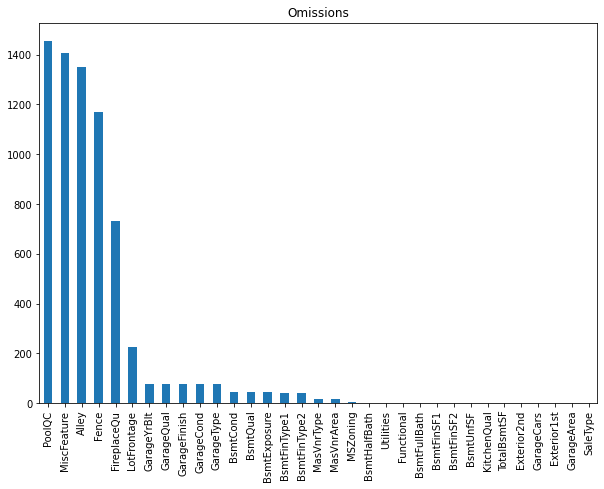

In [6]:
missing = test.isnull().sum().sort_values(ascending=False)
missing[missing > 0].plot(kind='bar', figsize=(10, 7))
plt.title('Omissions');

In [7]:
 test.isnull().sum()[test.isnull().sum()>0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

Убираем все пропуски, так как в них нет информативности, и выведем для наглядности:

In [8]:
limit = len(test)*0.4 

for col in test.columns:
    if test[col].isnull().sum() >= limit:
        test.drop(col, axis=1, inplace=True)
        print(col, ': column deleted')

Alley : column deleted
FireplaceQu : column deleted
PoolQC : column deleted
Fence : column deleted
MiscFeature : column deleted


In [9]:
 test.isnull().sum()[test.isnull().sum()>0]

MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64

Заполним пропуски значениями:

In [10]:
for col in test.columns[test.dtypes == 'float64']:
  test[col] = test[col].fillna(test[col].mean())

for col in test.columns[test.dtypes == 'int64']:
 test[col] = test[col].fillna(test[col].mean())

for col in test.columns[test.dtypes == 'object']:
  test[col] = test[col].fillna(test[col].value_counts().idxmax())
  
test.isnull().sum()[test.isnull().sum()>0]

Series([], dtype: int64)

### Подготовка данных для train

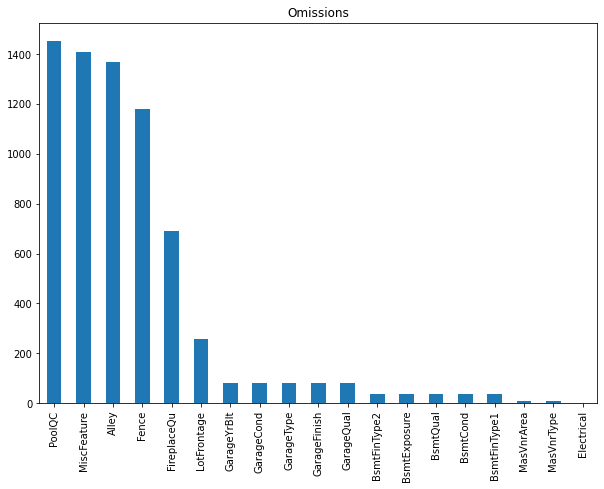

In [11]:
missing = train.isnull().sum().sort_values(ascending=False)
missing[missing > 0].plot(kind='bar', figsize=(10, 7))
plt.title('Omissions');

In [12]:
 train.isnull().sum()[train.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Убираем все пропуски, так как в них нет информативности, и выведем для наглядности:

In [13]:
limit = len(train)*0.4 
    
for col in train.columns:
    if train[col].isnull().sum() >= limit:
        train.drop(col, axis=1, inplace=True)
        print(col, ': column deleted')

Alley : column deleted
FireplaceQu : column deleted
PoolQC : column deleted
Fence : column deleted
MiscFeature : column deleted


In [14]:
train.isnull().sum()[train.isnull().sum()>0]

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

Заполним пропуски значениями:

In [15]:
for col in train.columns[train.dtypes == 'float64']:
  train[col] = train[col].fillna(train[col].mean())

for col in train.columns[train.dtypes == 'int64']:
 train[col] = train[col].fillna(train[col].mean())

for col in train.columns[train.dtypes == 'object']:
  train[col] = train[col].fillna(train[col].value_counts().idxmax())
  
train.isnull().sum()[train.isnull().sum()>0]

Series([], dtype: int64)

### Обработка выбросов

In [16]:
 train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [17]:
 train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Визуализация параметрического распределения набора данных

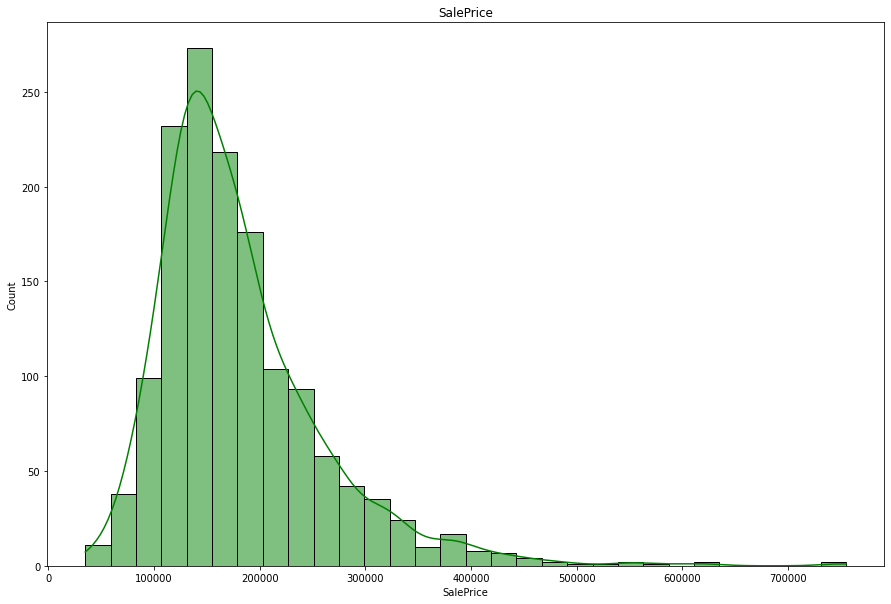

In [18]:
plt.figure(figsize=(15, 10))
sns.histplot(train.SalePrice, kde=True, bins=30, color='green')
plt.title('SalePrice');

Из блоков выше видим: среднее значение цены, наличие выбросов, среднеквадратическое отклонение, нормальное распеределение

<AxesSubplot:>

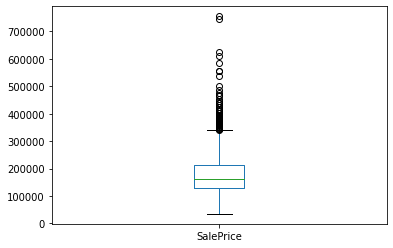

In [19]:
train['SalePrice'].plot.box()

Даграмма демонстрирует несимметричное распределение показателей.

In [20]:
 train['SalePrice'].describe(percentiles=[0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,1])

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
3%        82000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
98%      394931.060000
100%     755000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Обработаем выбросы:

In [21]:
train = train[train["SalePrice"]>=82000]
train = train[train["SalePrice"]<=394931] 

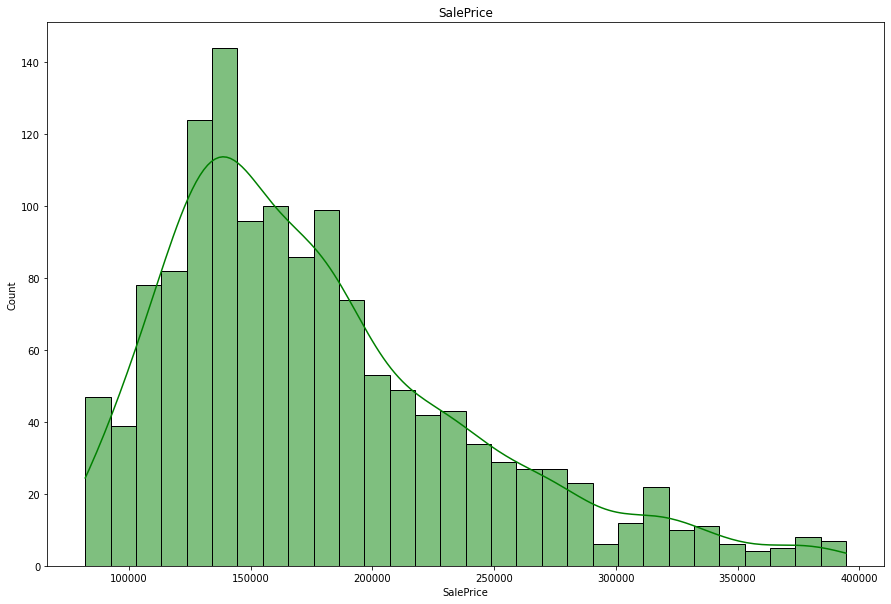

In [22]:
plt.figure(figsize=(15, 10))
sns.histplot(train.SalePrice, kde=True, bins=30, color='green')
plt.title('SalePrice');

<AxesSubplot:>

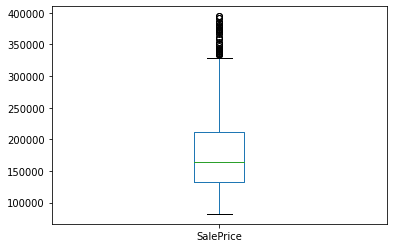

In [23]:
train['SalePrice'].plot.box()

In [24]:
train['SalePrice'].describe(percentiles=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98,1]) 

count      1387.000000
mean     177909.578226
std       63550.018084
min       82000.000000
5%        99620.000000
10%      110000.000000
20%      127000.000000
30%      137500.000000
40%      148200.000000
50%      164000.000000
60%      179200.000000
70%      197000.000000
80%      227000.000000
90%      270000.000000
95%      312850.000000
98%      345000.000000
100%     394617.000000
max      394617.000000
Name: SalePrice, dtype: float64

Уменьшили разброс с 78 до 62 тысяч

### Корреляция

In [25]:
df_corr = train.corr().unstack()

In [26]:
df_corr

Id         Id             1.000000
           MSSubClass     0.011025
           LotFrontage   -0.014956
           LotArea       -0.033802
           OverallQual   -0.019722
                            ...   
SalePrice  PoolArea       0.037703
           MiscVal       -0.009802
           MoSold         0.088616
           YrSold        -0.016845
           SalePrice      1.000000
Length: 1444, dtype: float64

In [27]:
df_corr[(df_corr > 0.8) & (df_corr < 1)]

GrLivArea     TotRmsAbvGrd    0.812563
TotRmsAbvGrd  GrLivArea       0.812563
GarageCars    GarageArea      0.869636
GarageArea    GarageCars      0.869636
dtype: float64

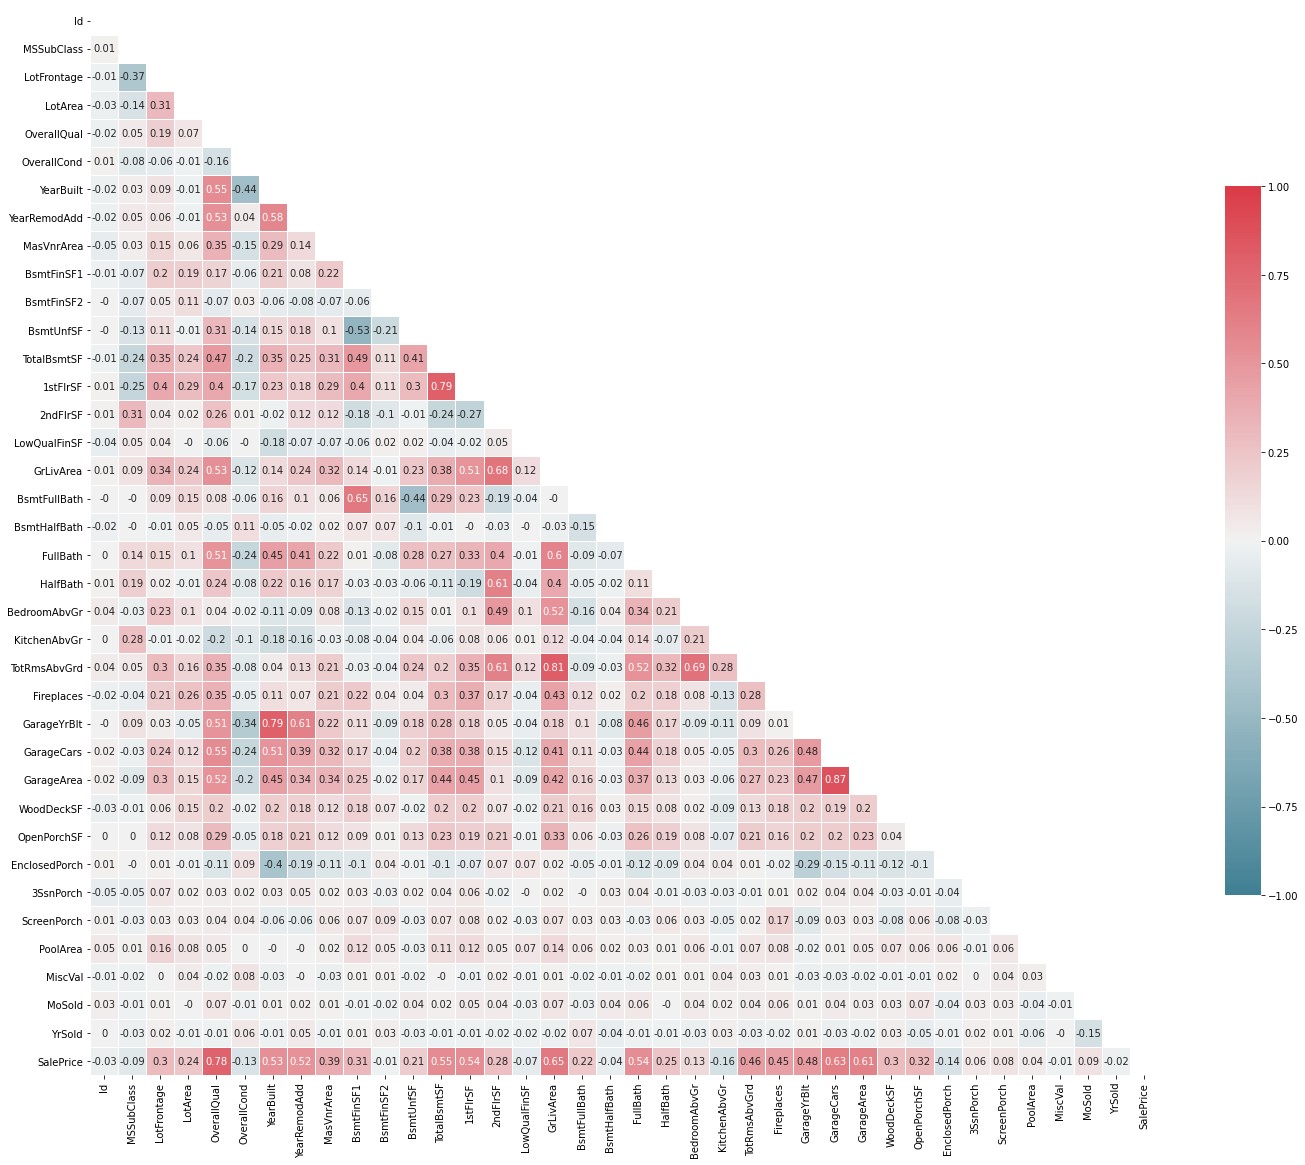

In [28]:
corr = train.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

In [29]:
train.drop(['1stFlrSF', 'TotRmsAbvGrd','GarageCars','Id'], axis=1, inplace=True)
test.drop(['1stFlrSF', 'TotRmsAbvGrd','GarageCars','Id'], axis=1, inplace=True)

In [30]:
df_corr = train.corr().unstack()
df_corr

MSSubClass  MSSubClass     1.000000
            LotFrontage   -0.365501
            LotArea       -0.140911
            OverallQual    0.046001
            OverallCond   -0.080955
                             ...   
SalePrice   PoolArea       0.037703
            MiscVal       -0.009802
            MoSold         0.088616
            YrSold        -0.016845
            SalePrice      1.000000
Length: 1156, dtype: float64

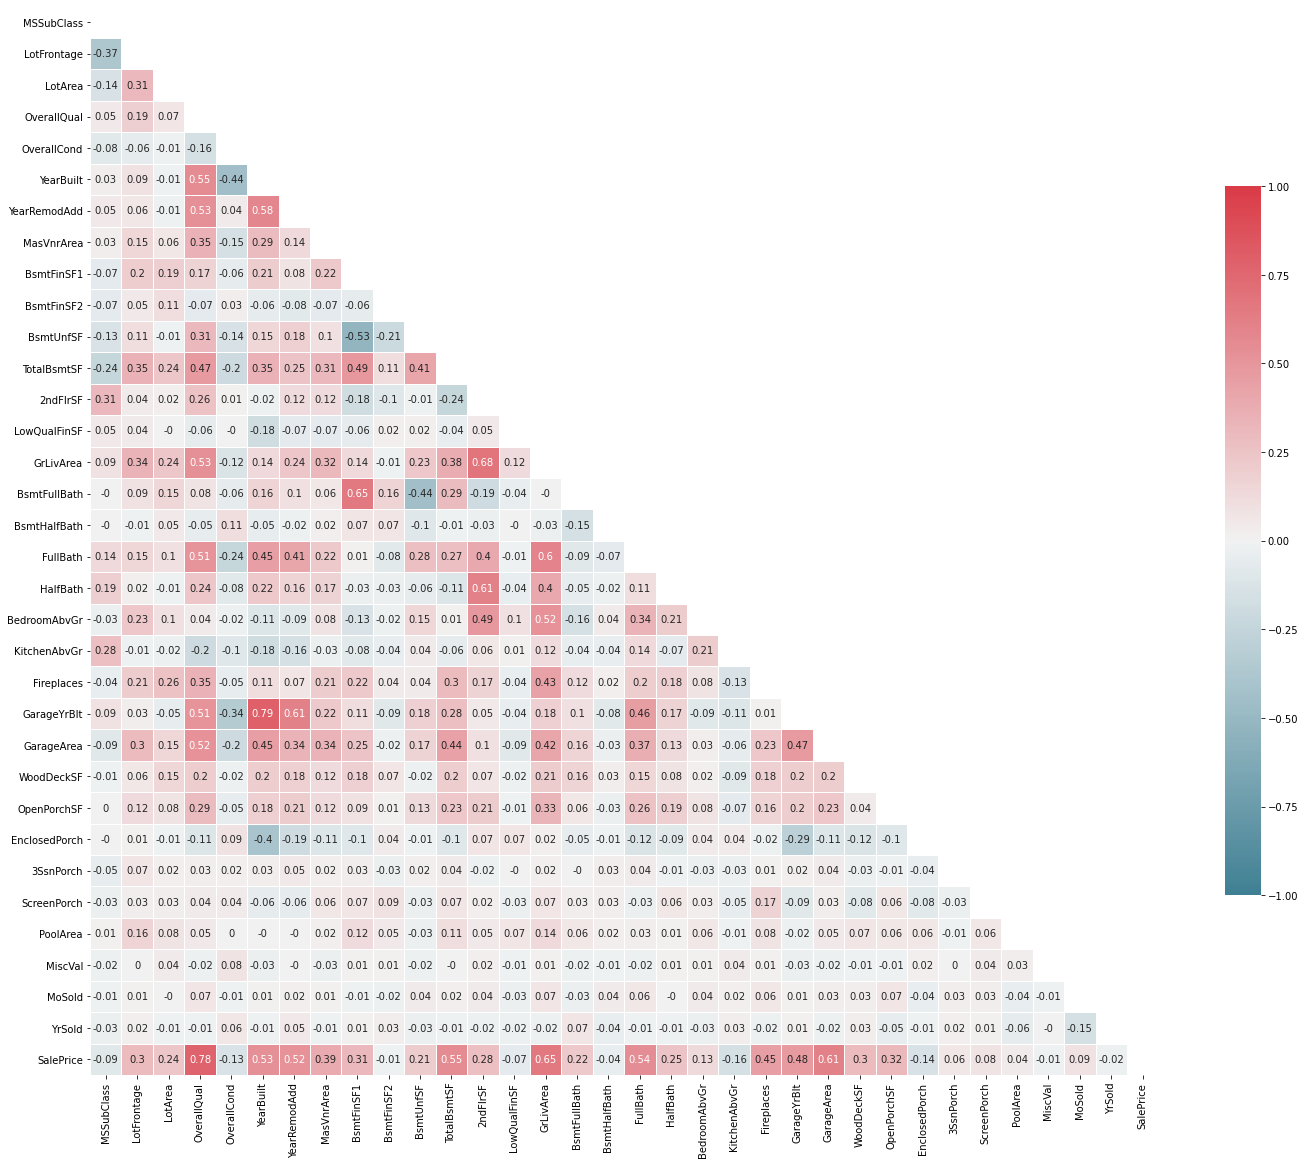

In [31]:
corr = train.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

In [32]:
train.drop(['OverallQual', 'KitchenAbvGr','EnclosedPorch'], axis=1, inplace=True)
test.drop(['OverallQual', 'KitchenAbvGr','EnclosedPorch'], axis=1, inplace=True)

In [33]:
df_corr = train.corr().unstack()
df_corr

MSSubClass  MSSubClass     1.000000
            LotFrontage   -0.365501
            LotArea       -0.140911
            OverallCond   -0.080955
            YearBuilt      0.027778
                             ...   
SalePrice   PoolArea       0.037703
            MiscVal       -0.009802
            MoSold         0.088616
            YrSold        -0.016845
            SalePrice      1.000000
Length: 961, dtype: float64

In [34]:
df_corr[(df_corr > 0.8) & (df_corr < 1)]

Series([], dtype: float64)

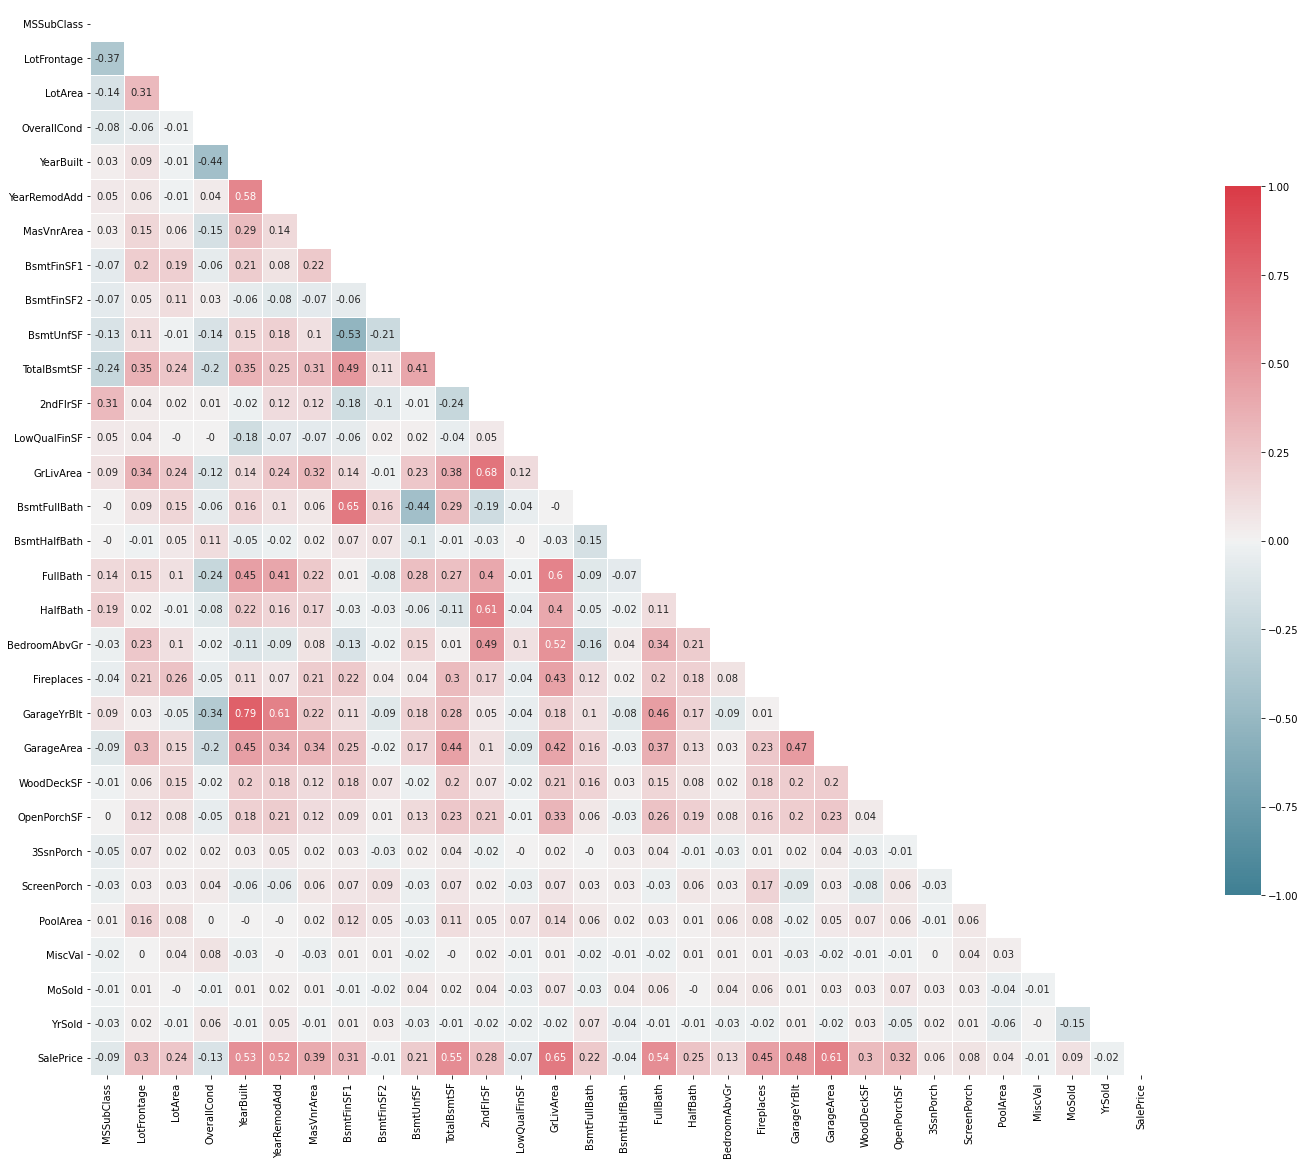

In [35]:
corr = train.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

In [36]:
train.drop(['OverallCond'], axis=1, inplace=True)
test.drop(['OverallCond'], axis=1, inplace=True)

### Обработка ненужных признаков

In [37]:
print(train['Street'].value_counts())

Pave    1383
Grvl       4
Name: Street, dtype: int64


In [38]:
print(train['Utilities'].value_counts())

AllPub    1386
NoSeWa       1
Name: Utilities, dtype: int64


 В первом случае наблюдается явный дисбаланс, во втором случае атрибут вообще не несёт никакой значимой для анализа информации.

In [39]:
train.drop(['Utilities', 'Street'], axis=1, inplace=True)
test.drop(['Utilities', 'Street'], axis=1, inplace=True)

### Обучение модели CatBoostRegressor

In [40]:
y = train['SalePrice']
X = train.drop('SalePrice', axis = 1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [42]:
cat_features_index = np.where(X.dtypes == object)[0]
cat_features_index

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 16, 17, 18, 19, 21, 22,
       23, 24, 25, 26, 27, 29, 33, 34, 35, 36, 45, 46, 48, 50, 52, 53, 54,
       63, 64])

In [43]:
cb = CatBoostRegressor(random_state = 1, loss_function="RMSE", l2_leaf_reg=1,
                       verbose=200, thread_count=-1, iterations = 10000)

In [44]:
cb.fit(X_train, y_train, plot=True, use_best_model=True,eval_set=(X_test, y_test),
       cat_features=cat_features_index)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 62270.9828888	test: 62149.9122547	best: 62149.9122547 (0)	total: 80.4ms	remaining: 13m 24s
200:	learn: 17580.9398776	test: 19688.5274711	best: 19688.5274711 (200)	total: 5.49s	remaining: 4m 27s
400:	learn: 13147.4311319	test: 18482.2925615	best: 18479.7862665 (398)	total: 9.71s	remaining: 3m 52s
600:	learn: 10788.5597709	test: 18073.3443123	best: 18065.0365570 (598)	total: 13.5s	remaining: 3m 31s
800:	learn: 9208.1253949	test: 17938.6025283	best: 17934.4221378 (797)	total: 17.5s	remaining: 3m 21s
1000:	learn: 7935.0692038	test: 17844.7441129	best: 17844.7369292 (998)	total: 21.5s	remaining: 3m 13s
1200:	learn: 6998.1970952	test: 17792.9246274	best: 17788.9579557 (1159)	total: 25.6s	remaining: 3m 7s
1400:	learn: 6267.3263797	test: 17786.5957320	best: 17769.3535253 (1298)	total: 29.7s	remaining: 3m 2s
1600:	learn: 5640.0901413	test: 17772.7494782	best: 17763.4718253 (1502)	total: 33.9s	remaining: 2m 58s
1800:	learn: 5118.3153069	test: 17765.7153879	best: 17755.1192144 (1675)	to

In [45]:
train_pred = cb.predict(X_train, thread_count=-1)
y_pred = cb.predict(test, thread_count=-1)
val_pred = cb.predict(X_test, thread_count=-1)

Построим график:

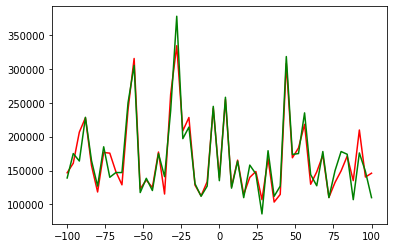

In [46]:
fig = plt.subplots()
plt.plot(np.linspace(-100, 100,51),val_pred[:255:5], color='red')
plt.plot(np.linspace(-100, 100,51),y_test[:255:5], color='green')

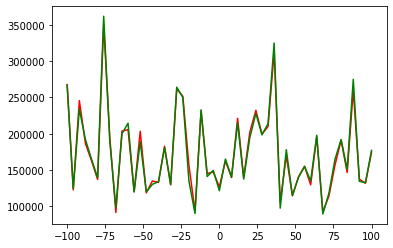

In [47]:
fig = plt.subplots()
plt.plot(np.linspace(-100, 100,51),train_pred[:255:5], color='red')
plt.plot(np.linspace(-100, 100,51),y_train[:255:5], color='green')

Можно заметить, что на контрольной выборке имеется неплохое приближение, не всегда точное, но модель почти справляется, а на тестовой выборке (второй график) апроксимация ещё лучше, что и следовало бы ждать. Итого 92,4%.

In [48]:
print('Mean Absolute Error:    ', mean_absolute_error(y_train,train_pred))  
print('Mean Squared Error:     ', mean_squared_error(y_train,train_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train,train_pred)))
print('R Squared:              ', r2_score(y_train,train_pred))

Mean Absolute Error:     4020.6125585629047
Mean Squared Error:      34987245.59189844
Root Mean Squared Error: 5915.001740650499
R Squared:               0.9913362809903898


In [49]:
print('Mean Absolute Error:    ', mean_absolute_error(y_test,val_pred))  
print('Mean Squared Error:     ', mean_squared_error(y_test,val_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test,val_pred)))
print('R Squared:              ', r2_score(y_test,val_pred))

Mean Absolute Error:     12727.344977221153
Mean Squared Error:      313358732.3047481
Root Mean Squared Error: 17701.9414840505
R Squared:               0.922141236114076


### Выведем результат

In [50]:
sample['SalePrice'] = y_pred
sample.head()

,Id,SalePrice
0,1461,125232.190547
1,1462,158078.025270
2,1463,179640.101429
3,1464,183664.459690
4,1465,188275.474918


In [51]:
sample.to_csv("answer.csv",index=False)

Таким образом, качество ответа в большей степени повысило избавление от пропусков и выбросов. Корреляция и избавление от ненужных признаков также сыграло небольшую роль.

### Сериализация

In [52]:
cb.save_model("../../app/models/cb")